In [1]:
#%matplotlib notebook
import sys
import os
#messi
# Standard modules used through the notebook 
import numpy as np
import matplotlib.pyplot as plt

# Tools specific for this tutorial
# They are in the .py files accompaining this notebook 
from bundle_adjust import ba_utils               
from bundle_adjust import rpc_fit
from IS18 import vistools               # display tools
from IS18 import utils                  # IO tools
from IS18 import rectification          # rectification tools
from IS18 import stereo                 # stereo tools
from IS18 import triangulation          # triangulation tools

import s2p
import pickle
import rpcm
import glob
import json
import copy
import timeit
import srtm4

# Display and interface settings (just for the notebook interface)
%load_ext autoreload
%autoreload 2
np.set_printoptions(linewidth=150)

### Experiment name 

In [2]:
exp_name = 'skysat_L1A_dona_juana2'
input_dir = os.path.join('exp/',exp_name)
src_dir = os.path.join('data/',exp_name)

if not os.path.exists(src_dir):
    print('ERROR: source path does not exist!')
else:
    os.makedirs(input_dir, exist_ok=True)

### Read SkySat images and RPCs

In [3]:
# read tiff images 
myimages = np.sort(glob.glob(src_dir+'/*.tif'))
#myimages = myimages[:3]
print('Found {} images'.format(len(myimages)))
n_cam = len(myimages)
print('Number of images to be used:', n_cam)
mycrops = []
myimg = []
for image in myimages:
    tmp = utils.readGTIFF(image)[:,:,0]
    myimg.append(utils.simple_equalization_8bit(tmp))
    mycrops.append({ 'crop': utils.simple_equalization_8bit(tmp), 'x0': 0.0, 'y0': 0.0 })

# load RPC coefficients
myrpcs = [rpcm.rpc_from_rpc_file(os.path.splitext(im)[0]+'_RPC.TXT') for im in myimages]
#myrpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]
print('Finished loading RPC coefficients')

# update myimages list
pickle_out = open(input_dir+'/myimages.pickle','wb')
pickle.dump([os.path.basename(imagefn) for imagefn in myimages], pickle_out)
pickle_out.close()

Found 9 images
Number of images to be used: 9
Finished loading RPC coefficients


### RPCs from projection matrices

In [4]:
#if not os.path.isdir(input_dir+'/rpc_from_P'):
#    os.mkdir(input_dir+'/rpc_from_P')

# rpc fitting starts here
verbose = True
for im_idx in range(len(myrpcs)):

    rpc_init = copy.copy(myrpcs[im_idx])
    h, w = mycrops[im_idx]['crop'].shape
    
    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
        input_P = np.array(json.load(f)['P_projective'])
    
    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 500, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    # warning: this is slow...
    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts, samples = p[idx_to_preserve], samples[idx_to_preserve]

    #fig = plt.figure(figsize=(20,6))
    #plt.imshow((mycrops[im_idx]['crop']), cmap="gray")
    #for k in range(proj_pts.shape[0]):
    #    plt.plot(*proj_pts[k][::-1], 'rx') 
    #plt.show()
    
    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)
    print('image {}, RMSE calibrated RPC = {}'.format(im_idx, err_calib))
    
    #rpc_calib_fn = os.path.basename(os.path.splitext(myimages[im_idx])[0])+'_rpc_adj.txt'
    #rpc_calib.write_to_file(input_dir+'/rpc_from_P/'+rpc_calib_fn)
    
    # check the histogram of errors if the RMSE error is above subpixel
    if err_calib > 1.0 and verbose:
        col_pred, row_pred = rpc_calib.projection(lon, lat, alt)
        err = np.sum(abs(np.hstack([col_pred.reshape(-1, 1), row_pred.reshape(-1, 1)]) - target), axis=1)
        plt.figure()
        plt.hist(err, bins=30);
        plt.show()

    myrpcs[im_idx] = copy.copy(rpc_calib)

image 0, RMSE calibrated RPC = 0.00021362534745121838
image 1, RMSE calibrated RPC = 0.00019487129182668933
image 2, RMSE calibrated RPC = 0.000233043801462547
image 3, RMSE calibrated RPC = 0.00014784612430271415
image 4, RMSE calibrated RPC = 0.00010054917810354038
image 5, RMSE calibrated RPC = 9.891166203417454e-05
image 6, RMSE calibrated RPC = 0.00017304405804614815
image 7, RMSE calibrated RPC = 0.0001943414368228454
image 8, RMSE calibrated RPC = 0.00016171454392056468


### Read projection matrices

In [5]:
cam_model = 'Perspective'
P_crop = []
for iter_cont in np.arange(len(mycrops)):
    with open(os.path.splitext(myimages[iter_cont])[0]+'_pinhole.json', 'r') as f:
        P_img = np.array(json.load(f)['P_projective'])
    P_crop.append(P_img/P_img[2,3])
    print('\rCamera {} / {} done'.format(iter_cont+1, len(mycrops)), end = '\r')
print('\nProjection matrices read')

Camera 9 / 9 done
Projection matrices read


### Set bundle adjustment input and load pipeline

In [8]:
ba_input_data = {}
ba_input_data['input_dir'] = input_dir
ba_input_data['n_adj'] = 0
ba_input_data['n_new'] = len(myimages)
ba_input_data['image_fnames'] = myimages
ba_input_data['crops'] = mycrops
ba_input_data['rpcs'] = myrpcs
ba_input_data['cam_model'] = 'Perspective'
ba_input_data['masks'] = None
ba_input_data['aoi'] = None

print('ba_input_data set!')

from bundle_adjust.ba_pipeline import BundleAdjustmentPipeline

ba_pipeline = BundleAdjustmentPipeline(ba_input_data, skysat=True, \
                                       use_masks=False, feature_detection_lib='opencv')
#ba_pipeline.display_aoi()

ba_input_data set!


### Run bundle adjustment

In [9]:
ba_pipeline.run()

Approximating RPCs as Perspective projection matrices
9 projection matrices / 9 (0 err)
Done!

Running skysat opencv based feature detection...

Parameters:
      use_masks:    False
      matching_thr: 0.6


Found 14938 keypoints in image 0
Found 14882 keypoints in image 1
Found 15805 keypoints in image 2
Found 14944 keypoints in image 3
Found 14134 keypoints in image 4
Found 14629 keypoints in image 5
Found 13990 keypoints in image 6
Found 14100 keypoints in image 7
Found 14513 keypoints in image 8

Detected features saved!

...done in 8.571168611757457 seconds

Computing pairs to be matched...

23 / 36 pairs to be matched
23 new pairs to be matched

...done in 0.005938783288002014 seconds

Matching...

Pair (0,1) -> 1405 matches
Pair (0,3) -> 307 matches
Pair (0,4) -> 43 matches
Pair (0,6) -> 55 matches
Pair (0,7) -> 7 matches
Pair (1,2) -> 1486 matches
Pair (1,3) -> 81 matches
Pair (1,4) -> 271 matches
Pair (1,5) -> 46 matches
Pair (1,6) -> 0 matches
Pair (1,7) -> 18 matches
Pair (

### Visualize a feature track before and after Bundle Adjustment

Verify that the projections after Bundle Adjustment are closer to the observations of the feature track.

Displaying feature track with index 1658

3D location (initial)  : [ 1738071.58579108 -6118152.46680213   510172.90968735]
3D location (after BA) : [ 1738039.44003011 -6118081.64955357   510179.65758488] 

 ----> Real 2D loc in im 4  (sol) =  [394.24639893 807.12536621]
 ----> Proj 2D loc in im 4  before BA =  [414.39530189 810.76703233]
 ----> Proj 2D loc in im 4  after  BA =  [393.64454623 807.01579804]
              Reprojection error beofre BA: 23.79056907553729
              Reprojection error after  BA: 0.7114208636269836


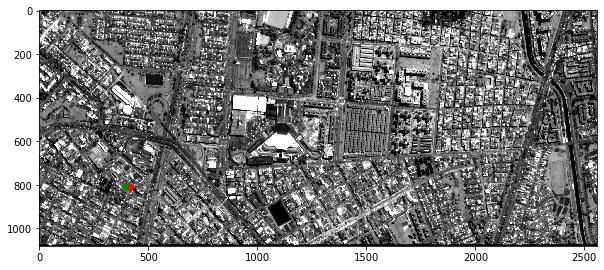

 ----> Real 2D loc in im 7  (sol) =  [533.54150391 816.6182251 ]
 ----> Proj 2D loc in im 7  before BA =  [516.80459061 814.51333344]
 ----> Proj 2D loc in im 7  after  BA =  [533.79494629 816.81078777]
              Reprojection error beofre BA: 18.84180495601288
              Reprojection error after  BA: 0.4460050508147333


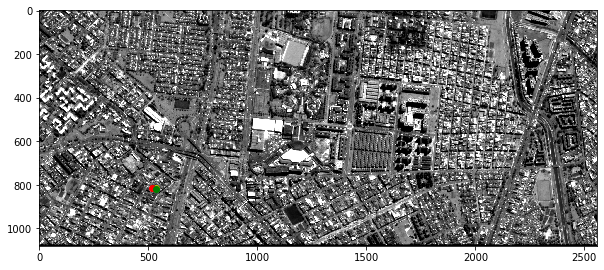

 ----> Real 2D loc in im 8  (sol) =  [520.87164307  81.43102264]
 ----> Proj 2D loc in im 8  before BA =  [510.03971657  77.85056443]
 ----> Proj 2D loc in im 8  after  BA =  [521.28486747  81.37639106]
              Reprojection error beofre BA: 14.41238471015501
              Reprojection error after  BA: 0.46785598528462913


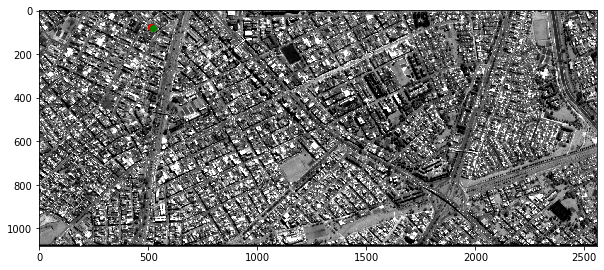

In [10]:
ba_pipeline.visualize_feature_track()

### Do the 3D points fall in the correct place?

Verify that the projection of the bounding box containing the point cloud of the scene falls in the correct area of the Earth.

In [11]:
from bundle_adjust.ba_triangulation import project_xyz_bbx_on_map

project_xyz_bbx_on_map(ba_pipeline.pts_3d_ba, map_zoom=14)

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

### Detailed view of initial-final reprojection errors for a particular image

This can be used to analyse a particular image in detail.

image 0, mean abs reproj error before BA: 7.1478
image 0, mean abs reproj error after  BA: 0.2894


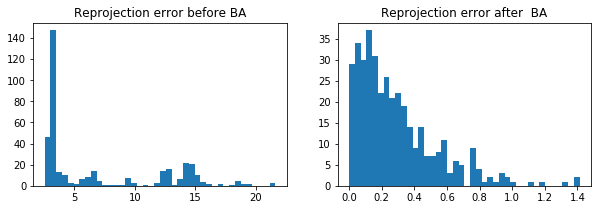

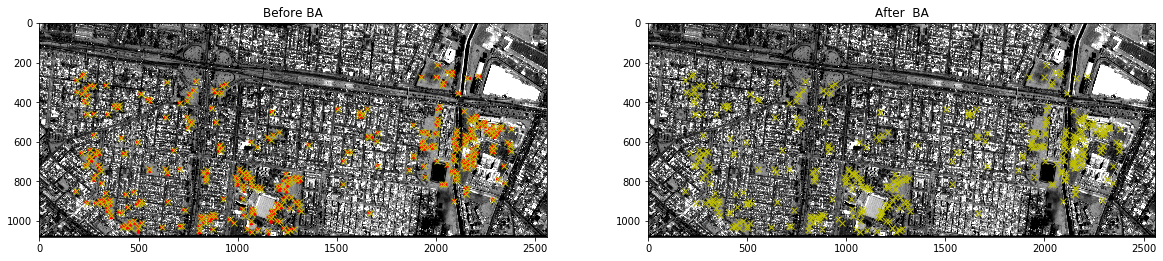

In [12]:
# set the index of the image to analyse
im_idx = 0

ba_pipeline.analyse_reproj_err_particular_image(im_idx, plot_features=True)

### Check baseline distances

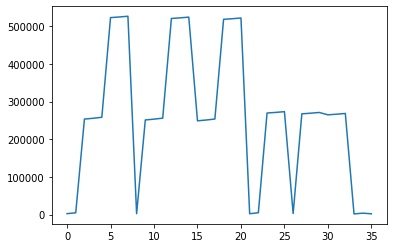

In [13]:
from bundle_adjust import ba_core

baseline_pairs, all_pairs_list = [], []
n_img = len(ba_pipeline.P_crop_ba)
for i in range(n_img):
    for j in range(i+1,n_img):

        # check if the baseline between both cameras is large enough
        _, _, _, optical_center1 = ba_core.decompose_perspective_camera(ba_pipeline.P_crop_ba[i])
        _, _, _, optical_center2 = ba_core.decompose_perspective_camera(ba_pipeline.P_crop_ba[j])
        baseline_pairs.append(np.linalg.norm(optical_center2 - optical_center1))
        all_pairs_list.append([i,j])

plt.plot(baseline_pairs)
plt.show()

<IPython.core.display.Javascript object>


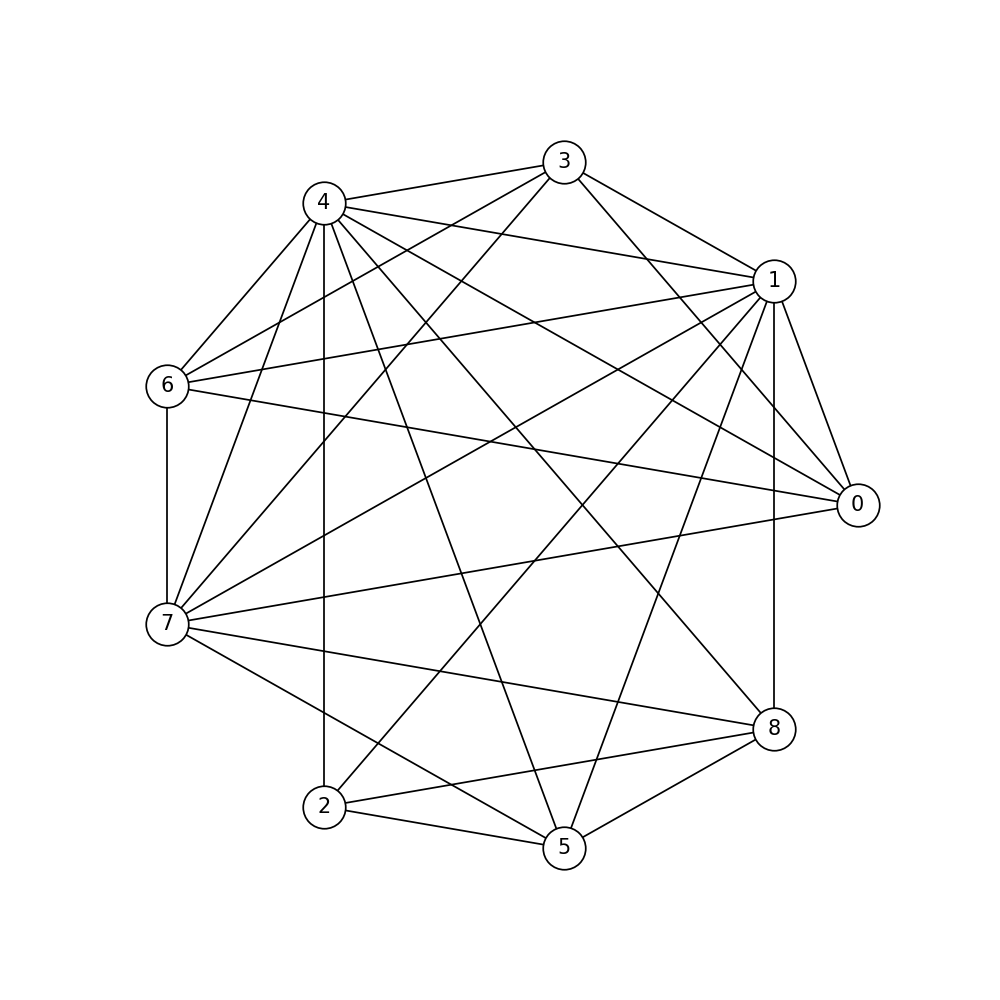

In [23]:
# check connectivity graph

ba_utils.plot_connectivity_graph(ba_pipeline.C, 10, save_pgf=False);

### Compare reprojection error using the L1A projection matrices or rpcs

In [15]:
from bundle_adjust import rpc_fit
import copy

original_rpcs = [rpcm.rpc_from_geotiff(x) for x in myimages]

for im_idx in range(n_cam):

    rpc_init = copy.copy(original_rpcs[im_idx])

    h, w = mycrops[im_idx]['crop'].shape

    with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            input_P = np.array(json.load(f)['P_projective'])

    # Calculate z_mean as average altitude of image's footprint 
    footprint = utils.get_image_longlat_polygon(myimages[im_idx])
    lon, lat = np.mean(footprint['coordinates'], axis=1)[0]
    z_mean = srtm4.srtm4(lon, lat)

    ecef_aoi_center = ba_utils.latlon_to_ecef_custom(lat, lon, z_mean)
    m1, m2, grid_size = 5*1e+3, 0, (40, 40, 40)
    x_min, x_max = ecef_aoi_center[0] - m1, ecef_aoi_center[0] + m1
    y_min, y_max = ecef_aoi_center[1] - m1, ecef_aoi_center[1] + m1
    z_min, z_max = ecef_aoi_center[2] - m1, ecef_aoi_center[2] + m1

    x_grid_coords = np.linspace(x_min, x_max, grid_size[0])
    y_grid_coords = np.linspace(y_min, y_max, grid_size[1])
    z_grid_coords = np.linspace(z_min, z_max, grid_size[2])
    x_grid, y_grid, z_grid = np.meshgrid(x_grid_coords, y_grid_coords, z_grid_coords)
    samples = np.zeros((x_grid.size, 3), dtype = np.float32)
    samples[:, 0] = x_grid.ravel()
    samples[:, 1] = y_grid.ravel()
    samples[:, 2] = z_grid.ravel()

    p = input_P @ np.vstack((samples.T, np.ones((1, samples.shape[0]))))
    p = (p[:2,:]/p[-1,:]).T
    idx_to_preserve = np.logical_and.reduce((p[:,0] >= 0 - m2, p[:,0] < h + m2, p[:,1] >= 0 - m2, p[:,1] < w + m2))
    proj_pts_P, samples = p[idx_to_preserve], samples[idx_to_preserve]

    lat, lon, alt = ba_utils.ecef_to_latlon_custom(samples[:, 0], samples[:, 1], samples[:, 2])

    # calibrate and get error
    input_im, input_ecef = mycrops[im_idx]['crop'], samples
    rpc_calib, err_calib = rpc_fit.fit_rpc_from_projection_matrix(rpc_init, input_P, input_im, input_ecef)

    rows, cols = original_rpcs[im_idx].projection(lon, lat, alt) # ROWS Y COL ESTAN AL REVES ?
    proj_pts_RPC = np.vstack((rows, cols)).T
    
    print('im {} max diff {}'.format(im_idx, max(np.linalg.norm(proj_pts_P-proj_pts_RPC,axis=1))))

im 0 max diff 1.624686264900918
im 1 max diff 1.295288347219448
im 2 max diff 1.4064774476400503
im 3 max diff 1.3336171271195465
im 4 max diff 1.1450193272163778
im 5 max diff 1.6989949632017207
im 6 max diff 1.709529139507347
im 7 max diff 1.4659059833670325
im 8 max diff 1.1507231546110115


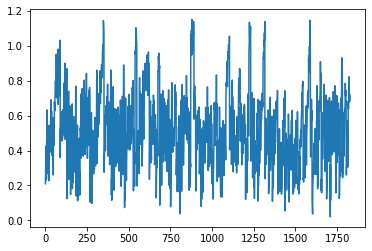

In [16]:
plt.plot(np.linalg.norm(proj_pts_P-proj_pts_RPC, axis=1))

### Plot optical centers in 3D

<IPython.core.display.Javascript object>


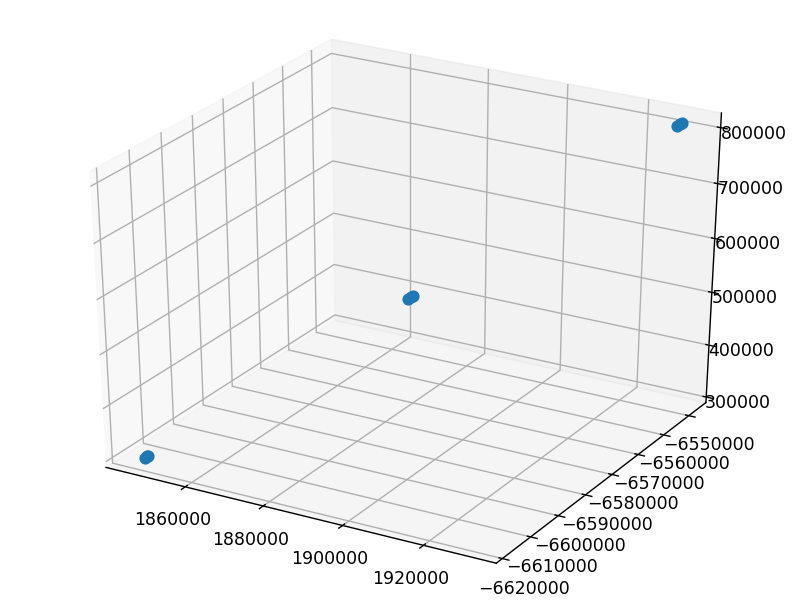

In [17]:
from bundle_adjust import rpc_utils

read_from_matrices = False
read_from_exterior_orientation = False

P_matrices = []
ocenters = []

if read_from_matrices:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            P_matrices.append(np.array(json.load(f)['P_projective']))
            _, _, _, optical_center1 = ba_core.decompose_perspective_camera(P_matrices[-1])
            ocenters.append(optical_center1)    
elif read_from_exterior_orientation:
    for im_idx in range(n_cam):
        with open(os.path.splitext(myimages[im_idx])[0]+'_pinhole.json', 'r') as f:
            tmp = json.load(f)['exterior_orientation']
            x_ecef, y_ecef, z_ecef = tmp['x_ecef_meters'], tmp['y_ecef_meters'], tmp['z_ecef_meters']
            ocenters.append(np.array([x_ecef, y_ecef, z_ecef]))
else: # read from rpcs approximation
    cam_model = 'Perspective'
    P_matrices = []
    for rpc, crop, iter_cont in zip(myrpcs, mycrops, np.arange(len(mycrops))):
        x, y, w, h = 0, 0, crop['crop'].shape[1], crop['crop'].shape[0]
        P_img = rpc_utils.approx_rpc_as_proj_matrix(rpc, [x,x+w,10], [y,y+h,10], \
                                                    [rpc.alt_offset - 100, rpc.alt_offset + 100, 10])
        _, _, _, optical_center1 = ba_core.decompose_perspective_camera(P_img/P_img[2,3])
        ocenters.append(optical_center1)
    
ocenters = np.array(ocenters)

%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)
ax.plot(ocenters[:,0], ocenters[:,1], ocenters[:,2], 'o')